In [23]:
import torch
from torch import optim
import torchvision
import torchvision.transforms as transforms
import os
import numpy as np
from matplotlib import pyplot as plt
import models
from modules import SModule
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [24]:
trace_head = "./pretrained"
fn_list = os.listdir(trace_head)
print(fn_list)

['saved_B_7.pt', 'QCIFARN1000', 'QCIFARN1000_Old', 'CIFARN1000', 'no_mask_list_7_0.5.pt', 'saved_B_3.pt', 'no_mask_list_11_0.2.pt', 'no_mask_list_2_0.2.pt', 'no_mask_list_0_0.2.pt', 'no_mask_list_9_0.5.pt', 'saved_B_2.pt', 'no_mask_list_5_0.5.pt', '.DS_Store', 'RESQ1000', 'saved_B_6.pt', 'no_mask_list_1_0.5.pt', 'no_mask_list_8_0.2.pt', 'no_mask_list_4_0.2.pt', 'saved_B_10.pt', 'saved_B_9.pt', 'saved_B_11.pt', 'saved_B_8.pt', 'saved_B_1_MLP4.pt', 'no_mask_list_6_0.2.pt', 'no_mask_list_10_0.5.pt', 'no_mask_list_3_0.5.pt', 'no_mask_list_6_0.5.pt', 'no_mask_list_3_0.2.pt', 'no_mask_list_10_0.2.pt', 'no_mask_list_8_0.5.pt', 'Q300', 'no_mask_list_1_0.2.pt', 'no_mask_list_4_0.5.pt', 'saved_B_1.pt', 'no_mask_list_9_0.2.pt', 'saved_B_5.pt', 'no_mask_list_5_0.2.pt', 'no_mask_list_7_0.2.pt', 'saved_B_4.pt', 'no_mask_list_2_0.5.pt', 'CIFARN300', 'saved_B_0.pt']


In [25]:
def GetSecond():
    optimizer.zero_grad()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # images = images.view(-1, 784)
        outputs, outputsS = model(images)
        loss = criteria(outputs, outputsS,labels)
        loss.backward()

BS = 128

trainset = torchvision.datasets.MNIST(root='~/Private/data', train=True,
                                    download=False, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS,
                                        shuffle=True, num_workers=2)

In [26]:
total_S_list= []
device = torch.device("cpu")
# for fn in tqdm(fn_list):
fn = "saved_B_3.pt"
this_S_list = []
model = models.SLeNet()
state_dict = torch.load(trace_head + "/" + fn, map_location="cpu")
model.load_state_dict(state_dict)
model.to(device)
model.push_S_device()
model.clear_noise()
model.clear_mask()
# model.normalize()
criteria = models.SCrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
GetSecond()

In [27]:
this_S_list = []
this_W_list = []
for m in model.modules():
    if isinstance(m, SModule):
        this_S_list += m.weightS.grad.data.view(-1).numpy().tolist()
        this_W_list += m.op.weight.data.view(-1).numpy().tolist()
this_S_list = np.array(this_S_list)
this_W_list = np.array(this_W_list)

In [28]:
torch.save([this_S_list, this_W_list], "stupid_nothing.pt")

(0.0, 200.0)

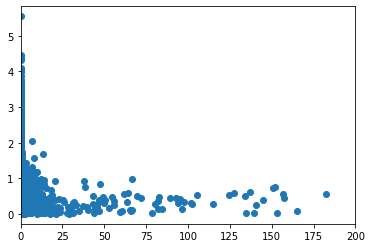

In [6]:
plt.scatter(this_S_list, np.abs(this_W_list))
plt.xlim(0,200)

In [7]:
log_S = np.log(this_S_list[this_S_list != 0])
log_W = np.log(this_W_list[this_S_list != 0])

<ipython-input-7-c49a688e0882>:2: RuntimeWarning: invalid value encountered in log
  log_W = np.log(this_W_list[this_S_list != 0])


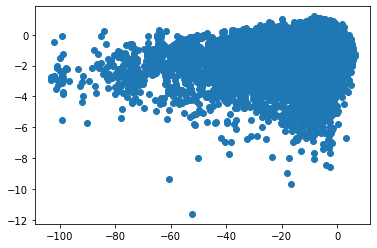

In [8]:
plt.scatter(log_S, log_W)

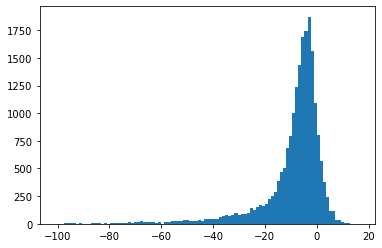

In [9]:
a = plt.hist(log_S - 2 * log_W, bins = 100)

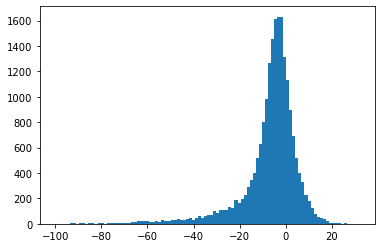

In [10]:
a = plt.hist(log_S - 4 * log_W, bins = 100)

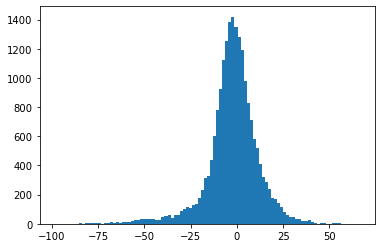

In [11]:
a = plt.hist(log_S - 8 * log_W, bins = 100)

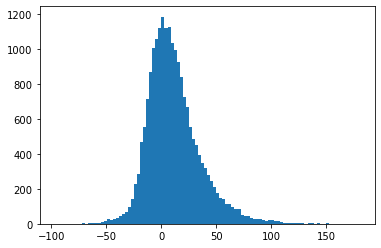

In [12]:
a = plt.hist(log_S - 20 * log_W, bins = 100)

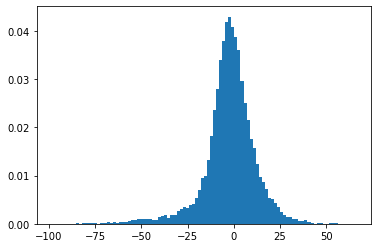

In [111]:
from scipy import stats as st
data = (log_S - 8 * log_W)
data = data[np.invert(np.isnan(data))]
# data = np.sqrt(np.abs(data)) * np.sign(data)
density = plt.hist(data, bins = 100, density=True)
DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,st.levy_stable,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,st.ncf,
        st.nct,st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

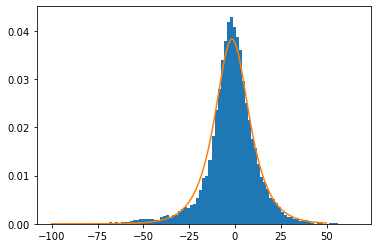

In [122]:
dist = DISTRIBUTIONS[40]
density = plt.hist(data, bins = 100, density=True)
try:
    lol = dist.fit(data)
    x = np.arange(-100, 50, 0.1)
    y = dist.pdf(x, *lol)
    plt.plot(x,y)
except:
    pass

In [113]:
print(DISTRIBUTIONS[40])
print(DISTRIBUTIONS[45])
print(DISTRIBUTIONS[62])
print(DISTRIBUTIONS[75])

In [7]:
import torch
from matplotlib import pyplot as plt
import numpy as np
a = torch.load("stupid_normal.pt")
b = torch.load("scale_normal.pt")

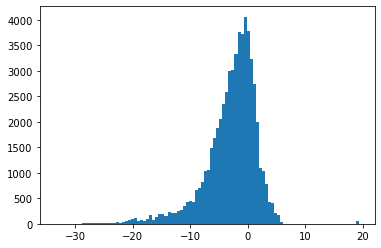

In [9]:
b_h = plt.hist(np.log(b[0][b[0]>0]), bins=100)

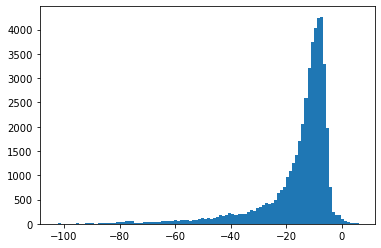

In [10]:
a_h = plt.hist(np.log(a[0][a[0]>0]), bins=100)

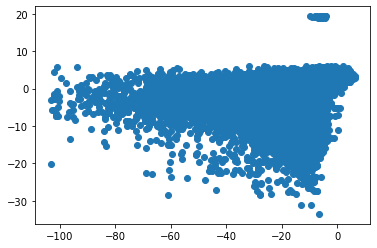

In [22]:
a_s = a[0]
b_s = b[0]
mapping = (a_s > 0) * (b_s > 0)
plt.scatter(np.log(a_s[mapping]), np.log(b_s[mapping]))

[ True  True  True ...  True  True  True]
